# Import Necessary Libraries

In [6]:
# Data Handling & Utilities
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Feature Extraction & Topic Modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Model Evaluation & Validation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Function: *balance_fake_real_articles(df)*

This function balances the dataset by ensuring an equal number of fake and real news articles using the following steps:

* Filter the DataFrame into two subsets: one for fake articles (label = 0) and one for real articles (label = 1).

* Determine the smaller count between the two subsets.

* Randomly sample that number of rows from both subsets to downsample the larger class.

* Concatenate the sampled fake and real articles into a new, balanced DataFrame.

* Print a message indicating the number of articles in each class.

* Return the balanced DataFrame.

This is useful for addressing class imbalance prior to training classification models.

In [7]:
def balance_fake_real_articles(df):
    df_fake = df[df['label'] == 0]
    df_real = df[df['label'] == 1]

    min_count = min(len(df_fake), len(df_real))

    df_fake_sampled = df_fake.sample(n=min_count, random_state=42)
    df_real_sampled = df_real.sample(n=min_count, random_state=42)

    df_balanced = pd.concat([df_fake_sampled, df_real_sampled], ignore_index=True)
    print(f"Balanced dataset created with {min_count} fake and {min_count} real articles.")
    return df_balanced

Apply the balancing to our pre-processed data (in a file called *all_articles_scraped.csv*)

In [29]:
df_full = pd.read_excel("CS439 Final Project/all_articles_scraped.xlsx")
df_balanced_with_articles = balance_fake_real_articles(df_full)

Balanced dataset created with 5755 fake and 5755 real articles.


# Text Processing and LDA

In [43]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_for_lda(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return tokens

df_balanced_with_articles['tokens'] = df_balanced_with_articles['article_text'].astype(str).apply(preprocess_for_lda)
df_balanced_with_articles['lda_ready_text'] = df_balanced_with_articles['tokens'].apply(lambda tokens: ' '.join(tokens))

vectorizer = CountVectorizer(max_features=1000)
X_counts = vectorizer.fit_transform(df_balanced_with_articles['lda_ready_text'])

lda_model = LatentDirichletAllocation(n_components=6, random_state=42)
X_topics = lda_model.fit_transform(X_counts)

topic_df = pd.DataFrame(X_topics, columns=[f"topic_{i}" for i in range(lda_model.n_components)])
df_with_topics = pd.concat([df_balanced_with_articles.reset_index(drop=True), topic_df], axis=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     /common/home/alg242/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /common/home/alg242/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Extract Topic Features

In [31]:
feature_names = vectorizer.get_feature_names_out()
custom_labels = {
    0: "Healthcare & Government Policy",
    1: "Entertainment – TV & Film",
    2: "Celebrity & Pop Culture",
    3: "Quotations & Public Statements",
    4: "Politics & Public Opinion",
    5: "Fashion, Lifestyle & Viral Trends"
}

for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    label = custom_labels.get(topic_idx, f"Topic {topic_idx}")
    print(f"{label} (Topic {topic_idx}): {', '.join(top_words)}")

Healthcare & Government Policy (Topic 0): said, star, instagram, love, time, day, family, photo, couple, baby
Entertainment – TV & Film (Topic 1): nan, image, dress, look, fashion, photo, hair, black, getty, red
Celebrity & Pop Culture (Topic 2): said, film, woman, time, year, actress, actor, also, role, new
Quotations & Public Statements (Topic 3): season, edit, first, prince, series, also, royal, wedding, game, year
Politics & Public Opinion (Topic 4): like, show, season, one, get, say, said, know, think, people
Fashion, Lifestyle & Viral Trends (Topic 5): award, year, song, album, best, music, american, new, million, first


In [48]:
topic_names = [
    "Government",
    "Entertainment",
    "Pop Culture",
    "Quotationss",
    "Politics",
    "Fashion"
]

# Visualizations and Metrics

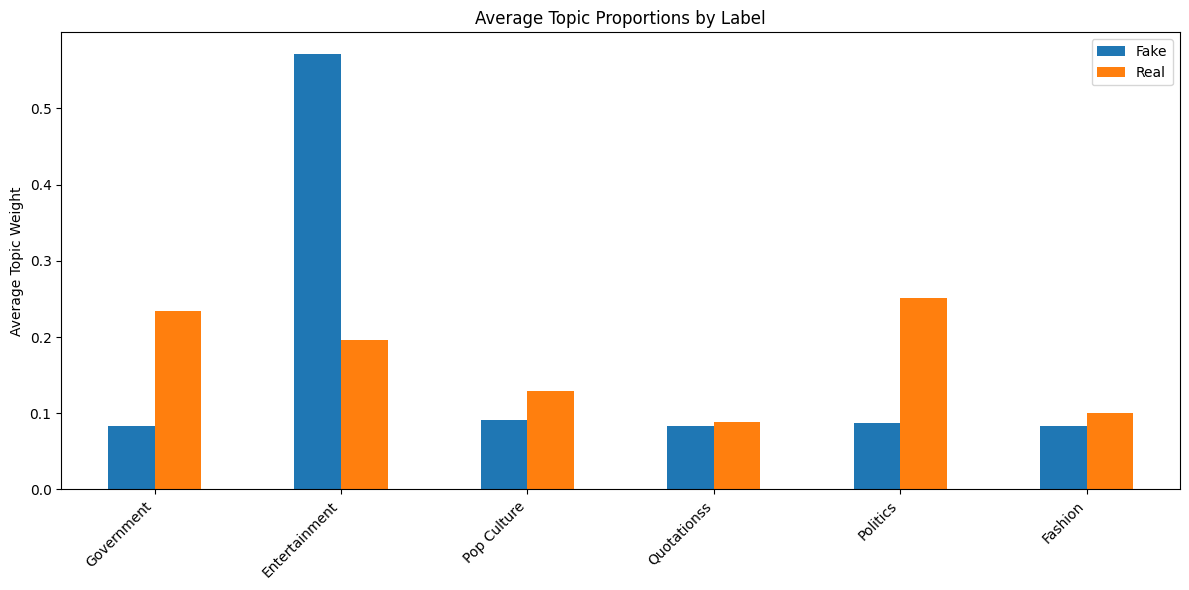

In [49]:
topic_df['label'] = df_with_topics['label']
topic_means = topic_df.groupby('label').mean().T
topic_means.columns = ['Fake', 'Real']
topic_means.index = topic_names

topic_means.plot(kind='bar', figsize=(12, 6), title="Average Topic Proportions by Label")
plt.ylabel("Average Topic Weight")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1174
           1       0.96      0.74      0.83      1128

    accuracy                           0.86      2302
   macro avg       0.88      0.85      0.85      2302
weighted avg       0.87      0.86      0.85      2302



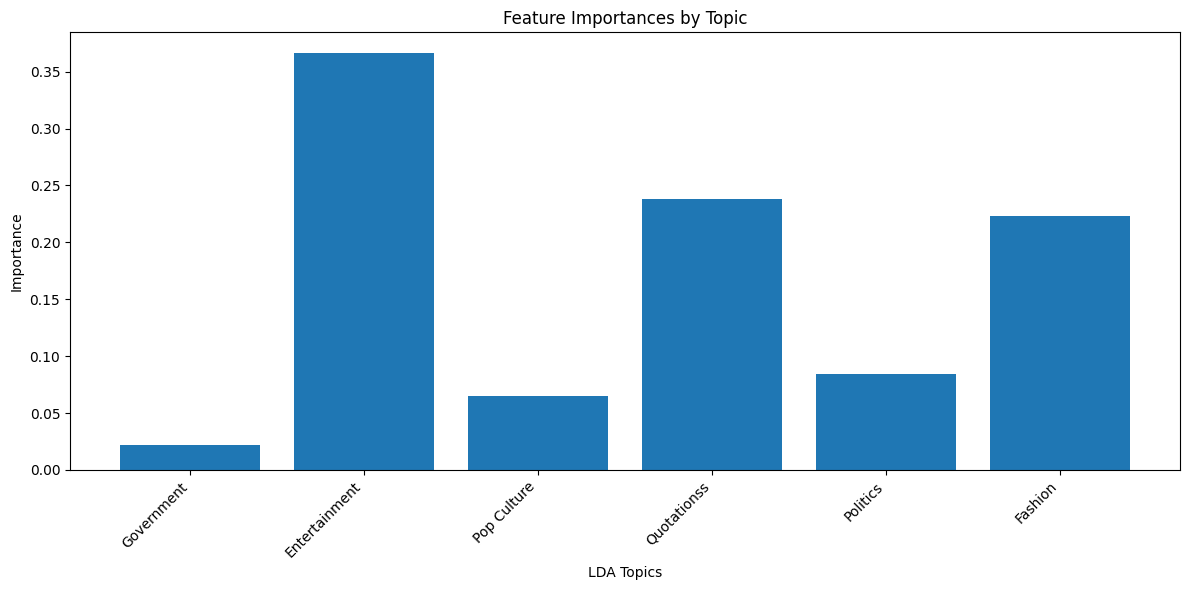

In [53]:
df_with_topics.rename(
    columns={f"topic_{i}": topic_names[i] for i in range(6)},
    inplace=True
)

X = df_with_topics[topic_names]
y = df_with_topics["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

importances = clf.feature_importances_
plt.figure(figsize=(12, 6))
plt.bar(topic_names, importances)
plt.title("Feature Importances by Topic")
plt.ylabel("Importance")
plt.xlabel("LDA Topics")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Logistic Regression


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.87      1151
           1       0.96      0.73      0.83      1151

    accuracy                           0.85      2302
   macro avg       0.87      0.85      0.85      2302
weighted avg       0.87      0.85      0.85      2302



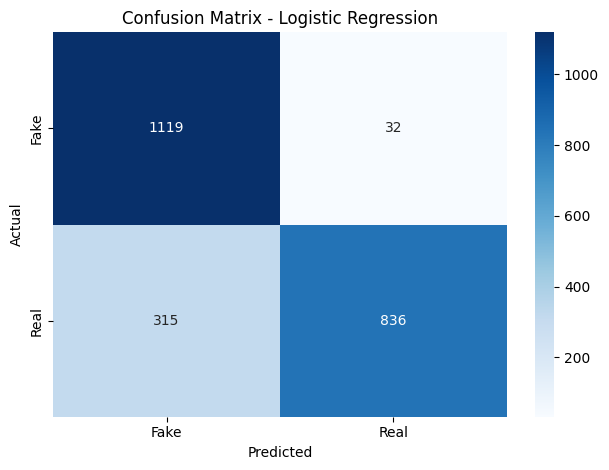

In [57]:
X = df_with_topics[topic_names]
y = df_with_topics["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

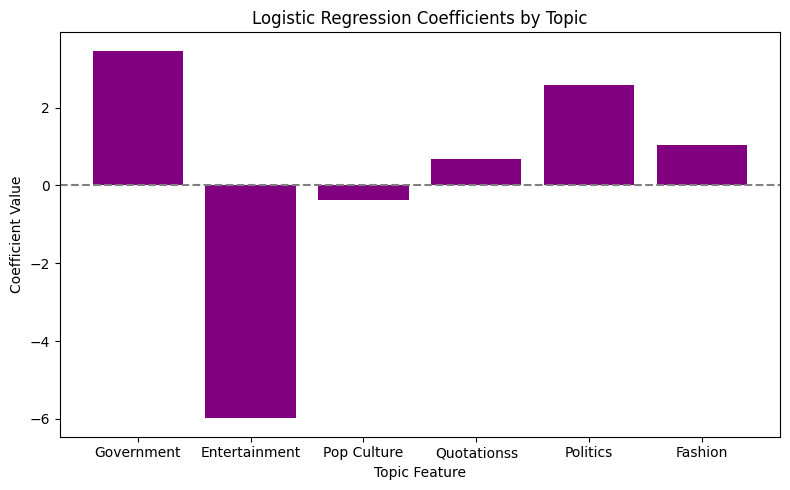

In [60]:
coefficients = logreg.coef_[0]
topic_labels = topic_names
plt.figure(figsize=(8, 5))
plt.bar(topic_labels, coefficients, color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Logistic Regression Coefficients by Topic")
plt.ylabel("Coefficient Value")
plt.xlabel("Topic Feature")
plt.tight_layout()
plt.show()

# Random Forest


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      1151
           1       0.97      0.75      0.85      1151

    accuracy                           0.86      2302
   macro avg       0.88      0.86      0.86      2302
weighted avg       0.88      0.86      0.86      2302



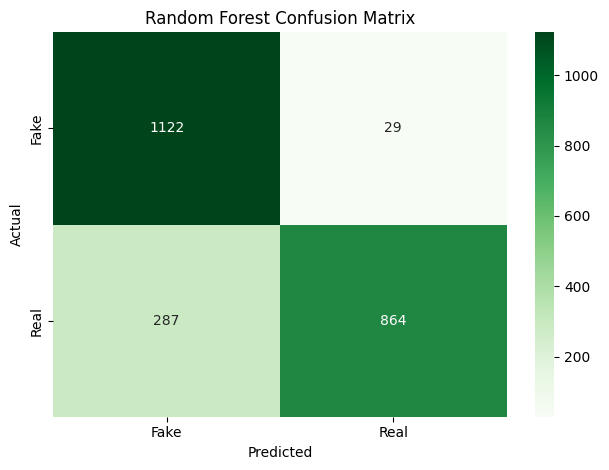

In [61]:
X = df_with_topics[topic_names]
y = df_with_topics["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# XGBoost


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1151
           1       0.97      0.75      0.85      1151

    accuracy                           0.86      2302
   macro avg       0.88      0.86      0.86      2302
weighted avg       0.88      0.86      0.86      2302



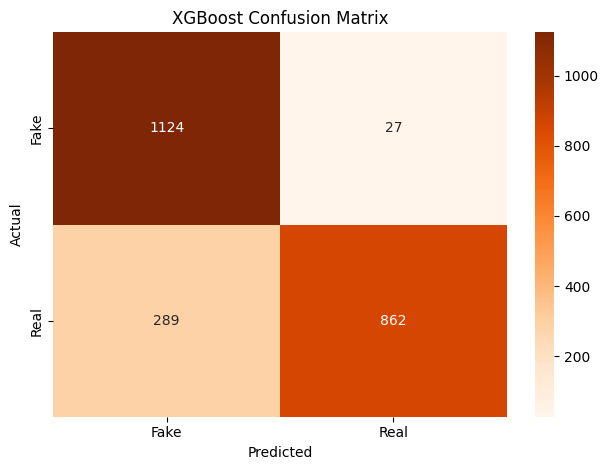

In [62]:
X = df_with_topics[topic_names]
y = df_with_topics["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Oranges", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Support Vector Machine (SVM)


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.86      1151
           1       0.96      0.72      0.83      1151

    accuracy                           0.85      2302
   macro avg       0.87      0.85      0.84      2302
weighted avg       0.87      0.85      0.84      2302



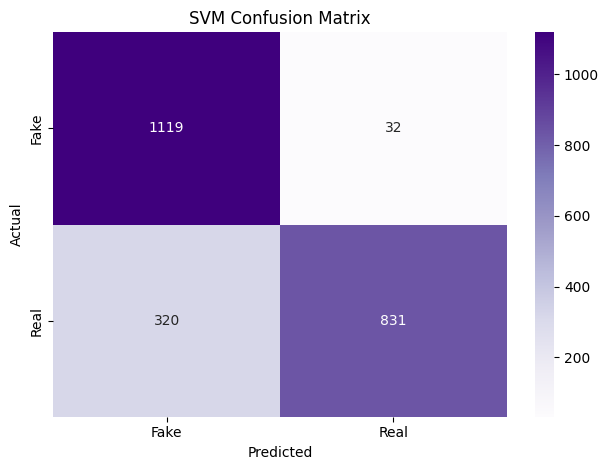

In [66]:
X = df_with_topics[topic_names]
y = df_with_topics["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Purples", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Cross-Validation

In [68]:
X = df_with_topics[topic_names]
y = df_with_topics["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

cv_scores = cross_val_score(xgb, X, y, cv=5, scoring='accuracy')
print("\nXGBoost 5-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))


XGBoost 5-Fold Cross-Validation Accuracy Scores: [0.85447437 0.86794092 0.85056473 0.84969592 0.85056473]
Mean CV Accuracy: 0.8546481320590791
